# ML в Биологии
## 7. Random Forest

In [57]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

from tqdm.notebook import tqdm
from time import time

import warnings
warnings.filterwarnings("ignore")

*Напоминаем, что во всех заданиях нашего курса, да и в реальной жизни, если вы получаете какие-то результаты, то надо сделать вывод!*

### Задача 1


В этой задаче вам предлагается исследовать зависимость качества предсказаний модели случайного леса в зависимости от различных гиперпараметров на примере задаче регрессии. Будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

В качестве данных возьмём следующие датасеты:

**Профиль физика:** https://www.kaggle.com/datasets/khsamaha/solar-flares-rhessi. Будем предсказывать длительность солнечных вспышек. Используйте файл с данными до 2018 года.

**Профиль биология:** https://archive.ics.uci.edu/dataset/1/abalone. Будем предсказывать возраст моллюсков.

*Совет.* При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для отслеживания времени работы можно использовать `tqdm` в циклах.

#### Загрузка и предобработка данных:

**Биология:**

In [3]:
data = pd.read_csv('abalone.data', names=['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
                                          'Shucked weight', 'Viscera weight', 'Shell weight',
                                          'Rings'])
data

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Уберем категориальный признак:

In [4]:
data = data.drop('Sex', axis=1)

In [5]:
X = data.drop('Rings', axis=1)
y = data['Rings'] + 1.5

Разбейте данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Посмотрите, как изменяется качество леса в зависимости от выбранных параметров. Для этого постройте графики зависимости MSE на тестовой выборке от количества деревьев (от 1 до 100) и от максимальной глубины дерева (от 3 до 25). Когда варьируете один из параметров, в качестве другого берите значение по умолчанию. Для того, чтобы исследовать зависимость от количества деревьев, обучите лес **один** раз и посчитайте предсказания каждого отдельного дерева в лесу. После этого используйте усреднение первых $k$ предсказаний в качестве ответа для $k$ деревьев.

In [12]:
def cum_metric(model, metric, x_test, y_test):
    '''
    Считает значение метрики в зависимости от количества деревьев в модели случайного леса.

    В этой функции для оценки влияния количества деревьев мы обучаем случайный лес один раз
    и вычисляем предсказания каждого дерева. Далее усредняем первые k предсказаний для k деревьев.

    Параметры:
    model (RandomForestRegressor): Обученная модель случайного леса.
    metric (function): Функция для вычисления метрики (например, mean_squared_error).
    x_test (array-like): Признаки тестовой выборки.
    y_test (array-like): Метки тестовой выборки.

    Возвращает:
    numpy.array: Массив значений метрики для каждого числа деревьев от 1 до n_estimators.
    '''

    predictions_by_estimators = [est.predict(x_test) for est in model.estimators_]
    cumpred = np.array(predictions_by_estimators).cumsum(axis=0) / (np.arange(len(predictions_by_estimators)) + 1)[:, np.newaxis]
    cumacc = [metric(y_test, pred) for pred in cumpred]
    return np.array(cumacc)

Исследование зависимости от количества деревьев:

In [18]:
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
estimations = cum_metric(forest, mean_squared_error, X_test, y_test)

Построение графика MSE от количества деревьев:

Text(0.5, 1.0, 'Зависимость MSE от количества деревьев')

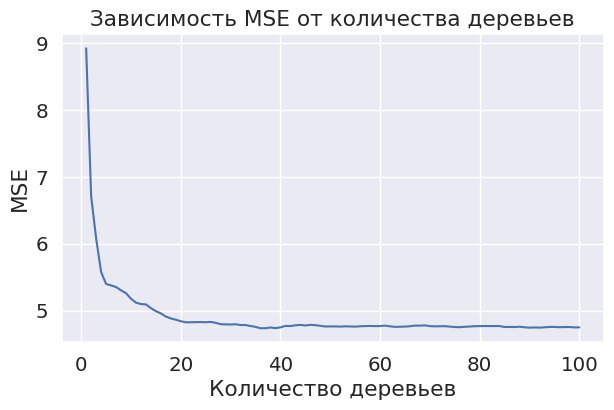

In [19]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 101), estimations)
plt.xlabel('Количество деревьев')
plt.ylabel('MSE')
plt.title('Зависимость MSE от количества деревьев')

Исследование зависимости от максимальной глубины:

In [20]:
res = []
depths = np.arange(3, 26)
for d in tqdm(depths, desc="Максимальная глубина"):
    forest = RandomForestRegressor(max_depth=d, random_state=42)
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    res.append(mean_squared_error(y_test, pred))

Максимальная глубина:   0%|          | 0/23 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Зависимость MSE от max_depth')

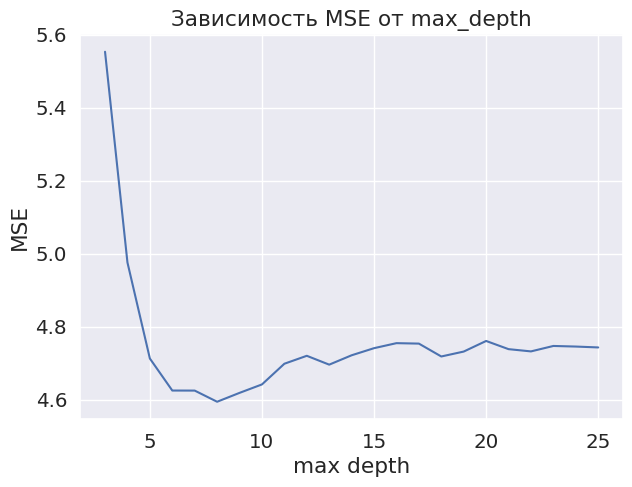

In [21]:
plt.figure(figsize=(7, 5))
plt.plot(depths, res)
plt.xlabel('max depth')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_depth')

Основываясь на полученных графиках, ответьте на следующие вопросы.

1. Какие закономерности можно увидеть на построенных графиках? Почему графики получились такими?

2. Как изменяется качество предсказаний с увеличением исследуемых параметров, когда эти параметры уже достаточно большие.

3. В предыдущем задании вы на практике убедились, что решающее дерево начинает переобучаться при достаточно больших значениях максимальной глубины. Справедливо ли это утверждение для случайного леса? Поясните свой ответ, опираясь на своё знание статистики.

**Ответ:**

Сначала ошибка значительно уменьшается, а затем стабилизируется, оставаясь на одном уровне при дальнейшем увеличении параметра. Однако при изменении количества деревьев ошибка на плато выглядит более сглаженной по сравнению с ситуацией, когда изменяется максимальная глубина.

Это можно объяснить тем, что при увеличении количества деревьев в лесу снижается дисперсия (variance), и усреднённый результат «голосования» деревьев становится все более стабильным, так что добавление новых деревьев уже мало влияет на ошибку.

В то же время чрезмерно большая глубина деревьев может привести к нестабильности и переобучению отдельных деревьев. Благодаря усреднению результатов, типичного для случайного леса, выраженного переобучения всей модели не происходит (каждое дерево переобучается «по-своему», и эти ошибки компенсируют друг друга), поэтому ошибка колеблется около некоторого среднего уровня, хотя некоторая нестабильность все же присутствует.


Обучите случайный лес с параметрами по умолчанию и выведите mse на тестовой выборке. Проведите эксперимент 3 раза. Почему результаты отличаются?

In [26]:
mses = []
for _ in range(3):
    forest = RandomForestRegressor()
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    mses.append(mse(y_test, pred))

In [27]:
print(*mses)

4.682945741626794 4.818781148325359 4.717935119617225


**Ответ:**

Выборка случайным образом разбивается на подвыборки, фичи для ветвления деревьев тоже выбираются случайным образом. Так что от перезапуска могут получаться немного различные результаты из-за этих стохастических компонент.

Было бы неплохо определиться с тем, какое количество деревьев нужно использовать и какой максимальной глубины они будут. Подберите оптимальные значения `max_depth` и `n_estimators` с помощью кросс-валидации.

In [28]:
estimator = RandomForestRegressor(random_state=42)

param_grid = {
      'max_depth': [5, 6, 7, 8, 9, 10],
      'n_estimators': [100, 117, 118, 119, 120, 121, 122]
  }

tree_gridsearch = GridSearchCV(estimator, param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

In [29]:
tree_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 117, 118, 119, 120, 121, 122]},
             scoring='neg_mean_squared_error')

Выведите найденные оптимальные параметры. Поясните, согласуются ли наблюдения с теорией.

In [30]:
tree_gridsearch.best_params_

{'max_depth': 8, 'n_estimators': 119}

**Вывод:**

В целом, результаты соответствуют теории: для хорошего качества нужно большое количество деревьев с достаточной глубиной. Однако чрезмерная глубина также нежелательна.

Зафиксируем эти оптимальные значения параметров и в дальнейшим будем их использовать.

In [31]:
max_depth = 8
n_estimators = 119

Оценим качество предсказаний обученного решающего леса.

In [32]:
forest = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)

forest.fit(X_train, y_train)

pred = forest.predict(X_test)

mse(y_test, pred)

4.645524865524077

Исследуйте зависимость метрики `mse` от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

Не забывайте делать пояснения и выводы!

In [33]:
train_res = []
test_res = []
max_features = np.arange(1, 8)

for m in tqdm(max_features):
    forest = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=m)
    forest.fit(X_train, y_train)

    train_pred = forest.predict(X_train)
    train_res.append(mse(y_train, train_pred))

    test_pred = forest.predict(X_test)
    test_res.append(mse(y_test, test_pred))

  0%|          | 0/7 [00:00<?, ?it/s]

Постройте график зависимости метрики mse на `test` и `train` в зависимости от числа признаков, использующихся при разбиении в каждой вершине.

Text(0, 0.5, 'MSE')

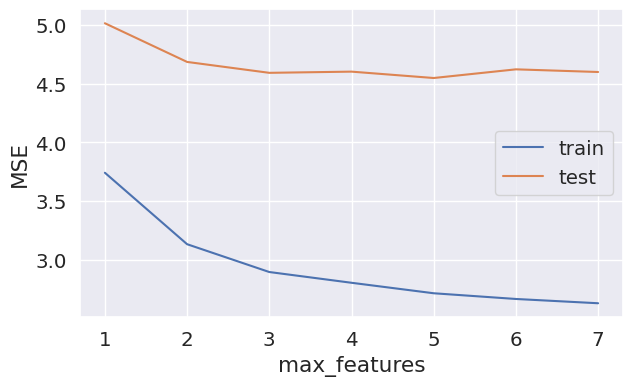

In [34]:
plt.figure(figsize=(7, 4))

plt.plot(max_features, train_res, label='train')
plt.plot(max_features, test_res, label='test')

plt.legend()

plt.xlabel('max_features')
plt.ylabel('MSE')

Почему график получился таким? Как зависит разнообразие деревьев от величины `n_features`?

**Ответ:**

Линия для обучающей выборки снижается с увеличением числа признаков, что логично: чем больше признаков разрешено использовать при одном ветвлении, тем легче модели запомнить данные.

Кривая для тестовой выборки выходит на плато (а затем может даже немного повыситься), так как увеличенное количество признаков ведёт к переобучению.

Кроме того, при слишком большом числе доступных признаков не происходит эффективного снижения дисперсии, так как деревья в лесу становятся более похожими друг на друга: при выборе признаков для ветвления рандомизация теряется, если доступны все признаки.

Поэтому в качестве оптимального значения выберу 3 признака, после которых кривая теста, как мне показалось, вышла на плато.

Зафиксируйте наилучшие гиперпараметры.

Проведите исследование скорости обучения и предсказания.

Засеките время обучения и предсказания, например, с помощью модуля `time`.



In [38]:
max_features = 3

forest = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

start_fit = time()
forest.fit(X_train, y_train)
stop_fit = time()

start_pred = time()
pred = forest.predict(X_test)
stop_pred = time()

print(f"Fitting time: {round(stop_fit - start_fit, 5)} секунд\nPrediction time: {round(stop_pred - start_pred, 5)} секунд")

Fitting time: 0.81145 секунд
Prediction time: 0.0167 секунд


Посчитайте среднюю глубину дерева в случайном лесе. Используйте функцию `get_depth()` для отдельных деревьев леса.
Посчитайте среднее количество листьев, используя функцию `get_n_leaves()` для отдельных деревьев.



In [39]:
depths = []
leaves = []

for tree in forest.estimators_:
    depths.append(tree.get_depth())
    leaves.append(tree.get_n_leaves())

In [40]:
print(f'Средняя глубина дерева: {np.mean(depths)}\nСреднее количество листьев: {np.mean(leaves)}')

Средняя глубина дерева: 8.0
Среднее количество листьев: 180.71428571428572


Сделайте выводы. Какие деревья обычно используются в случайном лесу? Как вы предполагаете, как от этого зависит скорость обучения и предсказания?

**Ответ:**

Деревья обычно используются с большой глубиной (здесь средняя глубина достигает максимально возможной) и с множеством разветвлений. Поэтому обучение занимает значительное время, и предсказания тоже выполняются не мгновенно.

Исследуйте важности признаков для следующих случаев:



*   Решающее  дерево
*   Случайный лес
*   Лес из первых 5-10 деревьев случайного леса из предыдущего пункта.

Также проанализируйте качество моделей выше.

Сделайте выводы. Отличаются ли посчитанные важности? Есть ли связь важностей признаков и качества моделей? О чем говорят посчитанные важности признаков?



In [41]:
def plot_importance(model, columns, title):

    global_importances = pd.Series(model.feature_importances_, index=columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')

    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(title)

In [42]:
tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)
pred = tree.predict(X_test)

mse(y_test, pred)

9.169377990430622

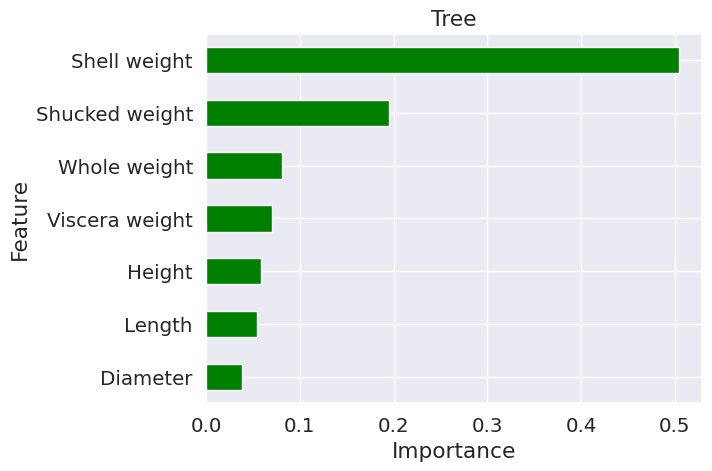

In [43]:
plot_importance(tree, X_train.columns, 'Tree')

In [44]:
pred = forest.predict(X_test)
mse(y_test, pred)

4.560110862368896

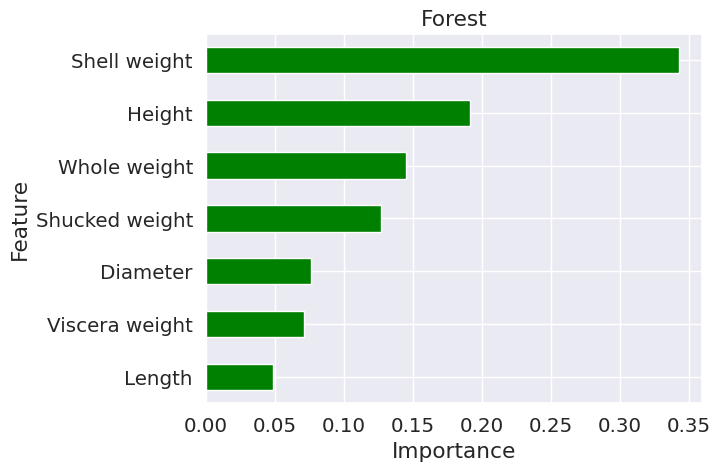

In [45]:
plot_importance(forest, X_train.columns, 'Forest')

In [46]:
forest.estimators_ = forest.estimators_[:5]
pred = forest.predict(X_test)
mse(y_test, pred)

4.923239986493577

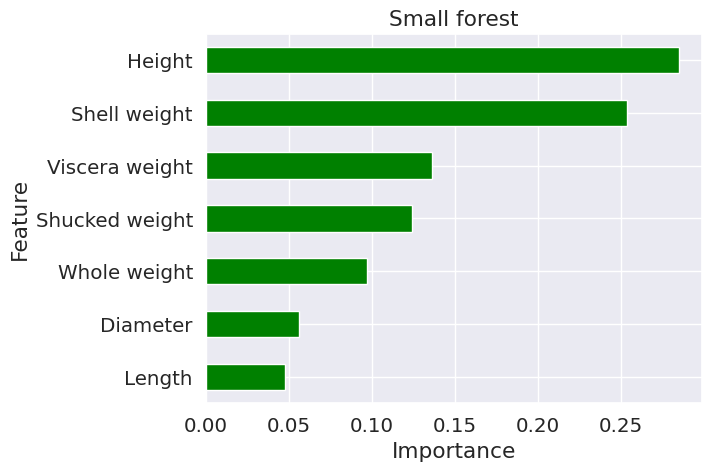

In [47]:
plot_importance(forest, X_train.columns, 'Small forest')

**Ответ:**

Признак "Shell weight" остаётся главным в каждом случае, вероятно, он объективно наиболее значим для предсказания.

Дальнейшие позиции по важности у дерева и леса распределяются по-разному. Также заметно, что лес придаёт немного больше значения остальным признакам по сравнению с деревом, создавая впечатление, что дерево почти полностью опирается на два ведущих признака.

Если строить предсказания, используя только первые 5 деревьев леса, соотношение важностей признаков заметно меняется: важность становится почти одинаковой для первых трёх признаков, а признаки со второго по четвёртый меняются местами. Важность же последних двух признаков остаётся практически неизменной.

Связь между значимостями признаков, вероятно, есть, но она не очевидна. У дерева и леса распределения важностей схожи, но значение MSE отличается почти в два раза.

### Задача 2

На лекции была получена формула bias-variance разложения для беггинга. Проведите эксперимент, в котором выясните, насколько уменьшается разброс (variance-компонента) беггинг-модели на 100 базовых моделях по отношению к одной базовой модели. Используйте данные из предыдущей задачи. Рассмотрите случайный лес и беггинг на моделях ридж-регрессии.


Для реализации данного эксперимента используйте класс беггинг-модели
`sklearn.ensemble.BaggingRegressor` , у которого используйте следующие поля:
* `base_estimator` — базовая модель;
* `max_features` — количество признаков для каждой базовой модели;
* `n_estimators` — количество базовых моделей.

Для решения задачи потребуется оценить корреляции предсказаний на тестовой выборке базовых моделей, входящих в состав беггинг-модели. Эти модели можно получить с помощью поля `estimators_` у обученной беггинг-модели. Корреляции моделей можно смотреть как корреляции векторов их предсказаний.

Насколько уменьшается разброс в каждом случае? Для каждого случая постройте также матрицу корреляций предсказаний базовых моделей и гистограмму по ним. Какую оценку коэффициента корреляции вы используете и почему?

In [48]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge

In [50]:
forest = RandomForestRegressor(n_estimators=100, max_features=3)
bagging = BaggingRegressor(estimator=Ridge(), max_features=3, n_estimators=100)

forest.fit(X_train, y_train)
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=Ridge(), max_features=3, n_estimators=100)

In [51]:
bagging_preds = []
forest_preds = []

for est, feature_inds in zip(bagging.estimators_, bagging.estimators_features_):
    features = X_test.columns[feature_inds]
    pred = est.predict(X_test[features])
    bagging_preds.append(pred)

for est in forest.estimators_:
    pred = est.predict(X_test)
    forest_preds.append(pred)

In [58]:
length = len(bagging_preds)
bag_corr_matrix = np.zeros((length, length))
for_corr_matrix = np.zeros((length, length))

for i in range(length):
    for j in range(length):
        bag_corr = pearsonr(bagging_preds[i], bagging_preds[j])[0]
        for_corr = pearsonr(forest_preds[i], forest_preds[j])[0]
        bag_corr_matrix[i, j] = bag_corr
        for_corr_matrix[i, j] = for_corr

Text(0.5, 1.0, 'Random Forest')

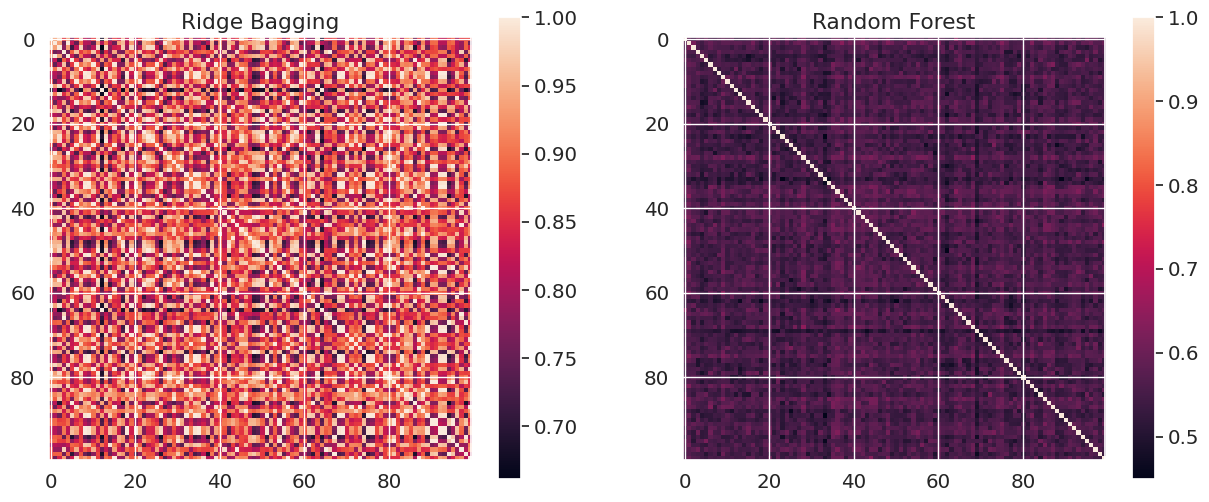

In [59]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))

im1 = axs[0].imshow(bag_corr_matrix)
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("Ridge Bagging")

im2 = axs[1].imshow(for_corr_matrix)
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Random Forest")

Отмечаем, что отдельные модели в Ridge-бэггинге демонстрируют высокую корреляцию, то есть бэггинг не снижает корреляцию между базовыми моделями в случае линейной регрессии.

Для случайного леса, напротив, наблюдается низкая корреляция между деревьями, что соответствует ожидаемому результату — модели в лесу остаются относительно независимыми.

Для оценки коэффициента корреляции был использован коэффициент корреляции Пирсона, так как линейная мера корреляции здесь вполне уместна.

Посмотрим теперь на гистограммы распределения коэффиуицентов корреляции в обоих случаях:

Text(0.5, 1.0, 'Random Forest')

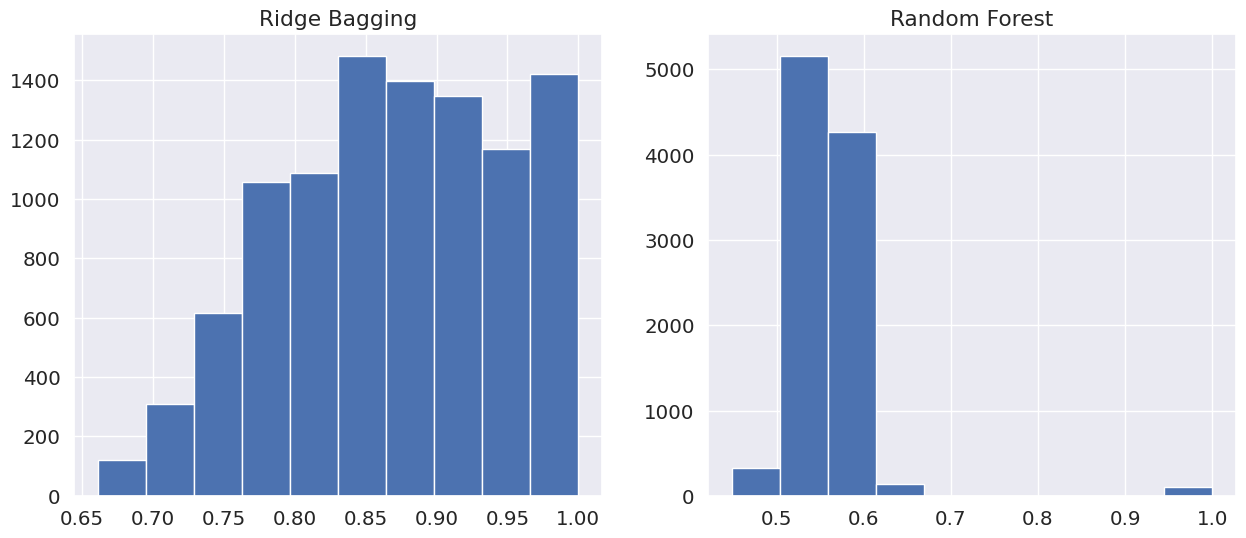

In [62]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))

axs[0].hist(bag_corr_matrix.reshape(-1))
axs[0].set_title("Ridge Bagging")

axs[1].hist(for_corr_matrix.reshape(-1))
axs[1].set_title("Random Forest")

Для ridge bagging корреляция охватывает широкий диапазон высоких значений (от 0.75 до 1), тогда как у случайного леса значения корреляции сосредоточены в диапазоне 0.4 - 0.6. Это также подтверждается визуально на тепловой карте.

Теперь проведем эксперимент: обучим n моделей для бэггинга, обычной ridge-регрессии, случайного леса и решающего дерева. Оценим разброс значений MSE на тестовой выборке, полученных этими моделями, и вычислим variance для результатов.

Отметим, что для ridge-регрессии будем обучать модель на случайно выбранных трех признаках, чтобы сохранить аналогичность с бэггингом (и обеспечить наличие разброса, так как в противном случае у линейной регрессии получится одно значение, ведь веса подбираются аналитически).

In [64]:
n_iter = 1000

bag_results = []
ridge_results = []

for_results = []
tree_results = []

for _ in tqdm(range(n_iter)):
    bagging = BaggingRegressor(estimator=Ridge(), max_features=3, n_estimators=100, n_jobs=-1)
    bagging.fit(X_train, y_train)
    bag_results.append(mse(y_test, bagging.predict(X_test)))

    ridge = Ridge()
    feature_indexes = np.random.choice(7, 3)
    features = X_train.columns[feature_indexes]
    ridge.fit(X_train[features], y_train)
    ridge_results.append(mse(y_test, ridge.predict(X_test[features])))

    forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    forest.fit(X_train, y_train)
    for_results.append(mse(y_test, forest.predict(X_test)))

    tree = DecisionTreeRegressor()
    tree.fit(X_train, y_train)
    tree_results.append(mse(y_test, tree.predict(X_test)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
bag_results  = np.array(bag_results)
tree_results = np.array(tree_results)
for_results  = np.array(for_results)
ridge_results = np.array(ridge_results)

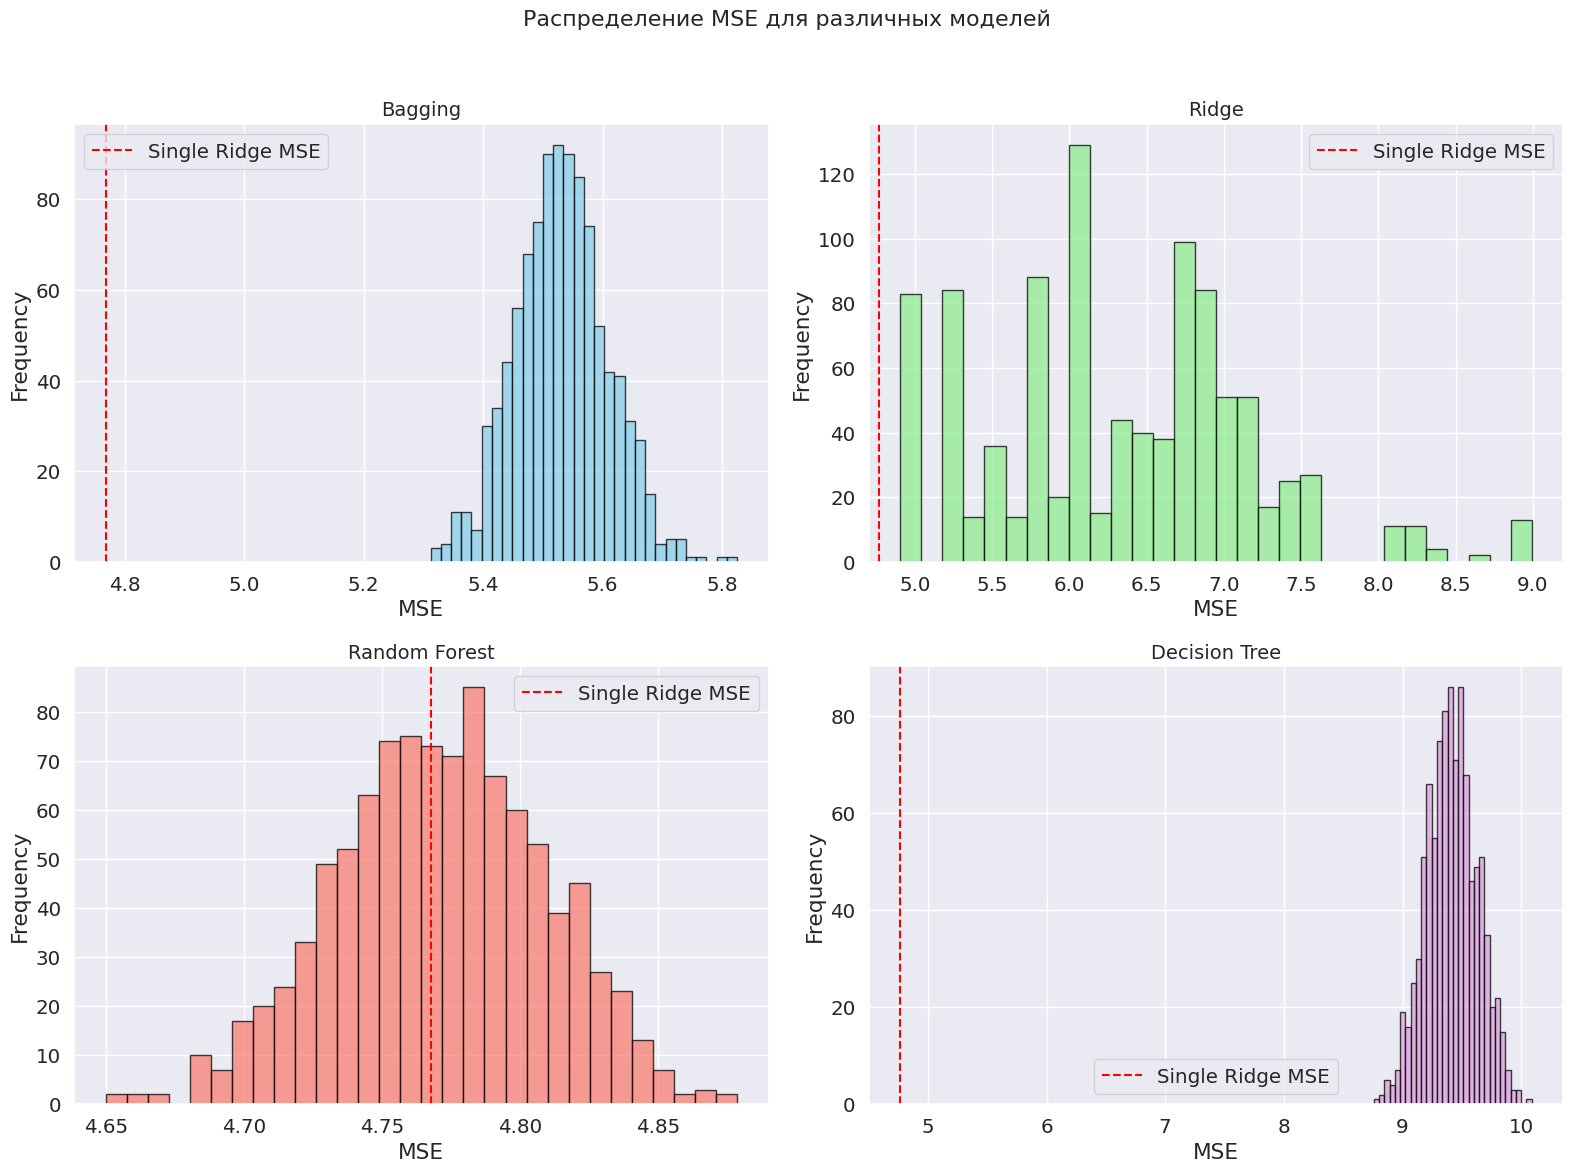

In [70]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Распределение MSE для различных моделей', fontsize=16)

plot_data = [
    (bag_results, 'Bagging', axs[0][0]),
    (ridge_results, 'Ridge', axs[0][1]),
    (for_results, 'Random Forest', axs[1][0]),
    (tree_results, 'Decision Tree', axs[1][1])
]

colors = ['skyblue', 'lightgreen', 'salmon', 'plum']
alpha = 0.75

for (data, title, ax), color in zip(plot_data, colors):
    ax.hist(data, bins=30, color=color, edgecolor='black', alpha=alpha)
    ax.set_title(title, fontsize=14)
    ax.axvline(r_mse, color='red', linestyle='--', linewidth=1.5, label='Single Ridge MSE')
    ax.legend()
    ax.set_xlabel('MSE')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])

Линейная регрессия возвращает только одно значение MSE, что вполне логично — веса вычисляются аналитически и не зависят от перезапуска. У бэггинга наблюдается небольшой разброс результатов, однако это не критично, поскольку у линейной регрессии и так очень низкая дисперсия.

В случае ридж-регрессии, обученной на случайных трех признаках, дисперсия становится заметной и даже превышает таковую у решающего дерева. Бэггинг успешно справляется с этой дисперсией, уменьшая её почти в 100 раз, что соответствует идеальному сценарию. Однако, такой подход умышленно ухудшает исходную линейную регрессию, что вызывает вопрос о целесообразности. Ошибка для одной ридж-регрессии, обученной на всех признаках, оказывается ниже, чем для всех моделей, использующих меньшее количество признаков, и, что более важно, ниже, чем у бэггинга.

При сравнении решающего дерева и случайного леса видно, что ошибка у дерева в целом выше, а также наблюдается больший разброс значений: у леса результаты колеблются вокруг среднего с разбросом примерно ±0.1, тогда как у дерева разброс составляет ±0.75.

Как видно ниже, дисперсия в случайном лесе уменьшилась примерно в 50 раз по сравнению с деревом. Это хороший результат, но всё же не идеальный, поскольку деревья в лесу немного скоррелированы.

In [69]:
print(f'Variance of bagging MSE score:       {bag_results.var()}')
print(f'Variance of ridge MSE score:         {ridge_results.var()}')
print(f'Variance of forest MSE score:        {for_results.var()}')
print(f'Variance of decision tree MSE score: {tree_results.var()}')

Variance of bagging MSE score:       0.005989720546277019
Variance of ridge MSE score:         0.7191233352791999
Variance of forest MSE score:        0.001437235777901003
Variance of decision tree MSE score: 0.04603146217256932


**Вывод:**

Мы убедились, что использование бэггинга для деревьев приносит хорошие результаты, тогда как для линейных моделей это оказывается неэффективным, а порой даже контрпродуктивным. Случайный лес действительно улучшает качество предсказаний и снижает дисперсию по сравнению с решающим деревом. В то же время бэггинг на линейных регрессиях показал худшие результаты по сравнению с простой линейной регрессией. Кроме того, в линейной регрессии нет значительной дисперсии, так как модель слишком проста, чтобы это имело смысл.